In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [14]:
news_df = pd.read_csv("./analysis result data/reuters_news_sentiment_data.csv")

In [15]:
dji_df = pd.read_csv("./daily data/DOW.csv")

dji_df['Date (Datetime)'] = pd.to_datetime(dji_df['Date'])

start_date = pd.Timestamp('2019-07-01')
end_date = pd.Timestamp('2020-07-01')
dji_df = dji_df[(dji_df['Date (Datetime)'] >= start_date) & (dji_df['Date (Datetime)'] < end_date)]

dji_df.drop(columns=["Date (Datetime)"], inplace=True)

In [16]:
dji_df["Sentiment"] = news_df["Sentiment"]
dji_df["Change"] = dji_df["Close"] - dji_df["Open"]

In [17]:
dji_df.set_index("Date", inplace=True)

In [18]:
chunkized = np.array_split(dji_df, 8)

best_shifts = []
best_spans = []
best_correlations = []
best_mean_correlation = 0

In [19]:
for i in tqdm.tqdm(range(1, 13)):
    chunkized = np.array_split(dji_df, i)
    best_shifts_in_chunk = [0] * i
    best_spans_in_chunk = [0] * i
    best_correlations_in_chunk = [0] * i

    for i, chunk in enumerate(chunkized):
        for span in range(0, 91):
            for shift in range(0, 11):
                chunk["Transformed Sentiment"] = chunk["Sentiment"].shift(shift)
                if span != 0:
                    chunk["Transformed Sentiment"] = chunk["Transformed Sentiment"].ewm(span=span).mean()
                corr = chunk["Transformed Sentiment"].corr(chunk["Change"], method="spearman")
                if corr > best_correlations_in_chunk[i]:
                    best_correlations_in_chunk[i] = corr
                    best_shifts_in_chunk[i] = shift
                    best_spans_in_chunk[i] = span

    if np.min(best_correlations_in_chunk) > best_mean_correlation:
        best_shifts = best_shifts_in_chunk
        best_spans = best_spans_in_chunk
        best_correlations = best_correlations_in_chunk


100%|██████████| 12/12 [00:54<00:00,  4.52s/it]


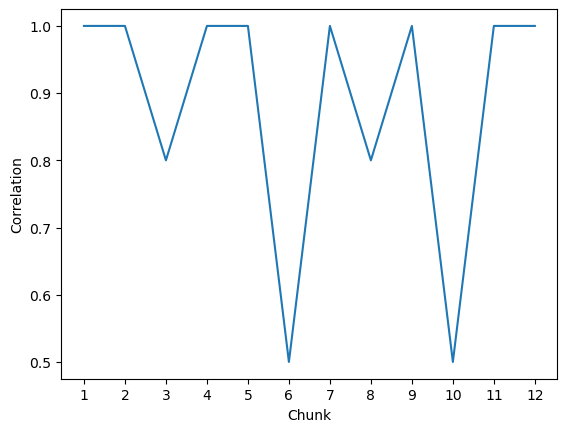

Optimal Correlations
[1.0, 0.9999999999999999, 0.7999999999999999, 1.0, 0.9999999999999999, 0.5, 0.9999999999999999, 0.7999999999999999, 0.9999999999999999, 0.5, 1.0, 0.9999999999999999]
-----------------------------------------------------------
Optimal Shifts (how many days back are we looking?)
[8, 9, 2, 8, 9, 7, 8, 6, 8, 7, 7, 8]
------------------------------------------------------------
Optimal EMA Spans
[0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0]


In [20]:
plt.plot(best_correlations_in_chunk)
plt.xticks(range(0, len(best_correlations)), range(1, len(best_correlations)+1))
plt.ylabel("Correlation")
plt.xlabel("Chunk")
plt.show()
print("Optimal Correlations")
print(best_correlations_in_chunk)
print("-----------------------------------------------------------")
print("Optimal Shifts (how many days back are we looking?)")
print(best_shifts_in_chunk)
print("------------------------------------------------------------")
print("Optimal EMA Spans")
print(best_spans_in_chunk)